# CBED matching for 061219 4DSTEM data

In [1]:
import os
import scipy.io as sio
import scipy.misc as smisc
import numpy as np
import re as regexp
import math
import matplotlib.pyplot as plt
import scipy

from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

import scipy.io
import time
import glob,os
import cv2
from scipy import optimize
from pylab import *

import imutils
import cv2

In [2]:
# Calculate mean scan profile from blank scan

RefPath = '/srv/home/chenyu/DEbackup/071519/S0/'
RefName = 'S0'
BeamLevel = 0
rx = 150
ry = 150
AccumulatedFrame = np.zeros((512,512))
for ix in range(rx):
    for iy in range(ry):
        filenum = ix*rx+iy+1
        frame = np.load(RefPath+'npy/'+RefName+'_'+format(filenum,'05')+'.npy')
        BeamLevel = BeamLevel + np.sum(frame)
        AccumulatedFrame = AccumulatedFrame + frame
AccumulatedFrame = AccumulatedFrame / rx / ry
BeamLevel = BeamLevel / rx / ry

13909484.803809032


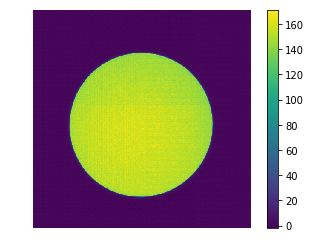

In [3]:
print(BeamLevel)
plt.imshow(AccumulatedFrame)
plt.axis('off')
plt.colorbar()
np.save(RefPath + 'BeamLevel.npy', BeamLevel)
np.save(RefPath + 'AccumualtedFrame.npy', AccumulatedFrame)

In [4]:
RefPath = '/srv/home/chenyu/DEbackup/071519/S0/'
BeamLevel = np.load(RefPath + 'BeamLevel.npy')
AccumulatedFrame = np.load(RefPath + 'AccumualtedFrame.npy')

/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


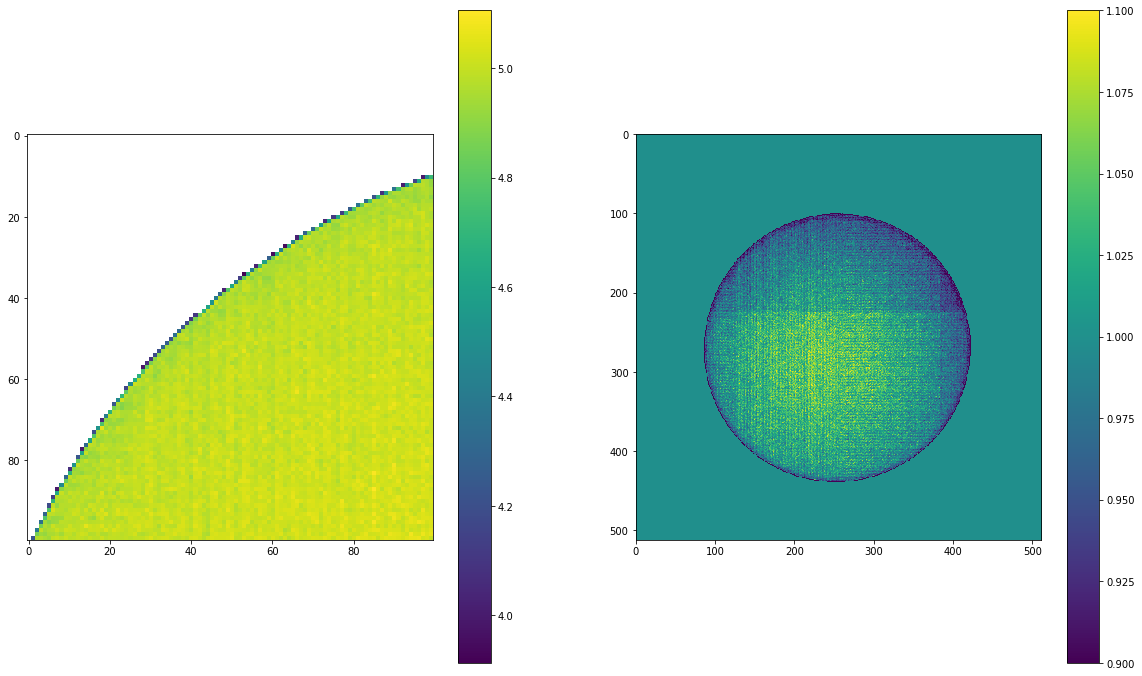

In [5]:
# Generate normalization mask
temp = AccumulatedFrame
temp[temp<0] = 0
fig = plt.figure(figsize=(20,12))
fig.add_subplot(121)
# tried to use 50 as threshold for mask1, will cause norm_mask value being too high, normalized exp intensity too low
mask1 = np.heaviside(AccumulatedFrame-50,1)
plt.imshow(np.log((temp*mask1)[100:200,100:200]))
plt.colorbar()

MeanBeamLevel = (mask1*AccumulatedFrame).sum()/np.count_nonzero(mask1)
norm_mask = AccumulatedFrame * mask1 / MeanBeamLevel
norm_mask[norm_mask==0] = 1
fig.add_subplot(122)
plt.imshow(norm_mask,clim=[0.9,1.1])
plt.colorbar()
np.save(RefPath + 'norm_mask.npy',norm_mask)

In [6]:
# build sub-area differential PACBED
Path = '/srv/home/chenyu/DEbackup/071519/S3/'
Name = 'S3'
rx = 150
ry = 150
PACBED = np.zeros((512,512))
for ix in range(75):
    for iy in range(75):
        filenum = ix*rx+iy+1
        frame = np.load(Path+'npy/'+Name+'_'+format(filenum,'05')+'.npy')
        frame_blank = np.load(RefPath + 'npy/S0_' + format(filenum,'05')+'.npy')
#         frame = frame - frame_blank
        PACBED = PACBED + frame
PACBED = PACBED / (ix+1) / (iy+1)

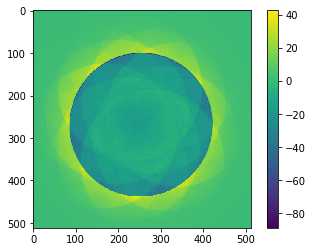

In [7]:
plt.imshow(PACBED - AccumulatedFrame)
plt.colorbar()

In [8]:
# Compare simulated PACBED from a unit cell to experiment PACBED
from scipy.ndimage import gaussian_filter
# simpath = '/srv/home/chenyu/antisite/PRISMATIC/Depth0_50FP/25.5mrad/25.5mrad/'
simpath = '/srv/home/chenyu/antisite/PRISMATIC/ConvAngle_noTilt/25.3mrad/25.3mrad/'
# simpath = '/srv/home/chenyu/antisite/PRISMATIC/Depth0_DWfactor/1.5x/25.5mrad/'
# simpath = '/srv/home/chenyu/antisite/PRISMATIC/Depth0_DWfactor/94573/25.3mrad/'
# simpath = '/srv/home/chenyu/antisite/PRISMATIC/Depth0_TiltSeries/0.0_0.5mrad/0.0_0.5mrad/'

# exppath = '/srv/home/chenyu/DEbackup/071519/S1/'
# PACBED_exp = np.load(exppath+'PACBED.npy')
# PACBED_exp = PACBED_exp/150/150
# thickness = np.load(exppath+'SrPeaks_thickness.npy')
# ABF = np.load(exppath+'ABF.npy')
# mask = np.heaviside(AccumulatedFrame-50,1)
mask = mask1
norm_mask = np.load('/srv/home/chenyu/DEbackup/071519/S0/norm_mask.npy')


# plt.imshow(PACBED_exp[0:100,0:100])
# plt.imshow(ABF[1:-1,:])
# plt.colorbar()

# PACBED_exp = PACBED_exp/BeamLevel
# PACBED_exp = (PACBED_exp*mask/norm_mask/BeamLevel)+PACBED_exp/BeamLevel*(1-mask)

PACBED_exp = PACBED
PACBED_exp = (PACBED_exp*mask/norm_mask/BeamLevel)+(PACBED_exp-AccumulatedFrame)/BeamLevel*(1-mask)

expMask = np.zeros((69,69))
expMask[21:43,22:44] = 1
px_list = np.nonzero(expMask)
sim_cube = np.load(simpath+'depth0_slice18_110pmss.npy')
row_list = px_list[0]
col_list = px_list[1]
file_list= row_list*69+col_list+1
PACBED_sim = np.zeros((328,328))
# PACBED_sim = np.zeros((488,488))

for ifile in range(file_list.size):
    frame = sim_cube[row_list[ifile],col_list[ifile],:,:]
    PACBED_sim = PACBED_sim + frame
    
PACBED_sim = PACBED_sim / file_list.size / 22
PACBED_sim = gaussian_filter(PACBED_sim,sigma=0.0)
print(np.sum(PACBED_exp))
print(np.sum(PACBED_sim))
# print(np.mean(thickness))


0.959983517541676
0.9912159954453672


In [74]:
# resample both simulation and experiment to a new grid, ranges from -40mrad to 40mrad with 1mrad/px

center_x = 256
center_y = 271
rotation = 73 + 90

final_size = 200

exp_pxsize = 0.149
sim_pxsize = 0.511

# Use a symmetric cutoff angle

collection_angle = min([center_x,center_y,512-center_x,512-center_y])
collection_angle = collection_angle * exp_pxsize

exp_x = np.linspace(-exp_pxsize*center_x, exp_pxsize*(511-center_x), num=512)
exp_y = np.linspace(-exp_pxsize*center_y, exp_pxsize*(511-center_y), num=512)
f_exp = scipy.interpolate.RectBivariateSpline(exp_y,exp_x,PACBED_exp)
final_x = np.linspace(-collection_angle,collection_angle,num=final_size)
final_y = np.linspace(-collection_angle,collection_angle,num=final_size)
final_xx, final_yy = np.meshgrid(final_x,final_y)
exp_recon = np.zeros((final_size,final_size))
exp_recon = f_exp.ev(final_xx,final_yy)
# exp_recon = exp_recon / exp_pxsize / exp_pxsize * sim_pxsize * sim_pxsize
        
sim_x = np.linspace(-sim_pxsize*164, sim_pxsize*(328-164), num=328)
# sim_x = np.linspace(-sim_pxsize*244, sim_pxsize*(488-244), num=488)
sim_y = sim_x
f_sim = scipy.interpolate.RectBivariateSpline(sim_x,sim_y,PACBED_sim)
sim_recon = np.zeros((final_size,final_size))
final_x = np.linspace(-collection_angle,collection_angle,num=final_size)
final_y = np.linspace(-collection_angle,collection_angle,num=final_size)
final_xx, final_yy = np.meshgrid(final_x,final_y)
final_xx_rotated = final_xx*math.cos(math.radians(rotation))-final_yy*math.sin(math.radians(rotation))
final_yy_rotated = final_yy*math.cos(math.radians(rotation))+final_xx*math.sin(math.radians(rotation))
sim_recon = f_sim.ev(final_xx_rotated,final_yy_rotated)
sim_recon = sim_recon / sim_pxsize / sim_pxsize * exp_pxsize * exp_pxsize

print('Collection angle limit: ' + str(collection_angle))

Collection angle limit: 35.909


[]

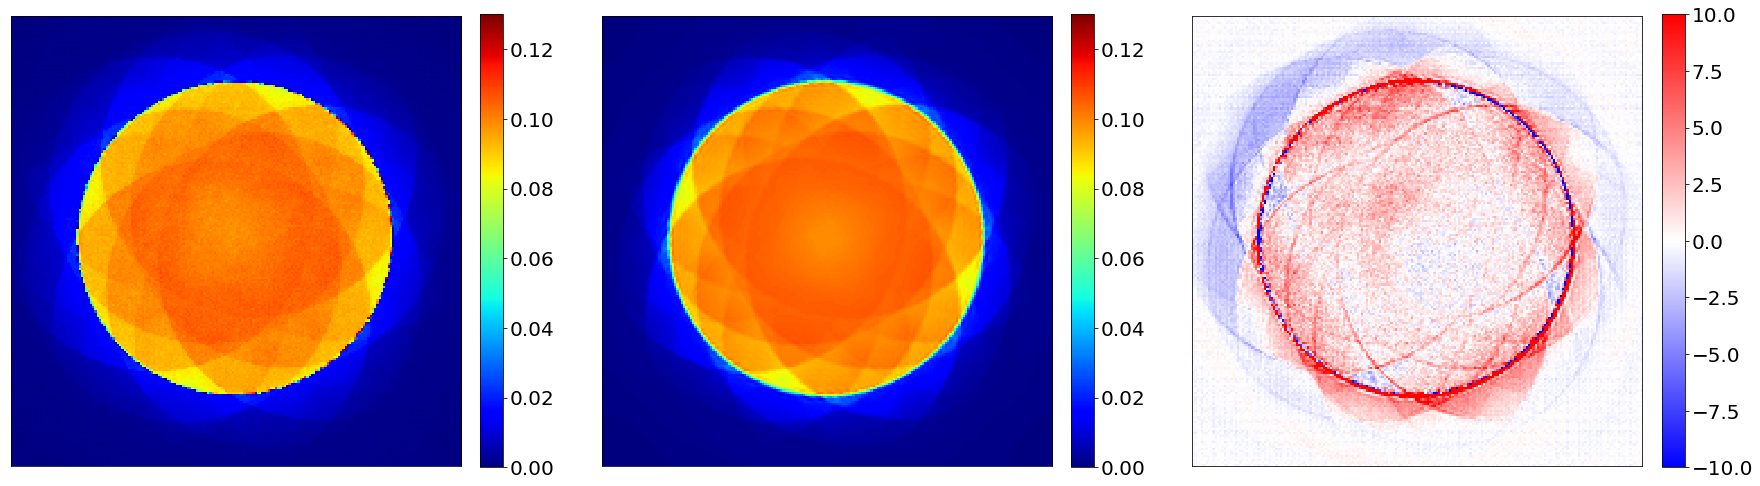

In [79]:
fig, ax = subplots(1,3,figsize=(30, 10))
im0 = ax[0].imshow(exp_recon*10000,clim=[0,0.13],cmap = plt.get_cmap('jet'))
im1 = ax[1].imshow(sim_recon*10000,clim=[0,0.13],cmap = plt.get_cmap('jet'))
# im1 = ax[1].imshow(sim_recon*10000)
cbar = plt.colorbar(im0,ax = ax[0], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20)
cbar = plt.colorbar(im1,ax = ax[1], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20)
im2 = ax[2].imshow(((sim_recon-exp_recon)*10000000
                   ),clim=[-10,10],cmap=plt.get_cmap('bwr'))
cbar = plt.colorbar(im2,ax = ax[2], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

[]

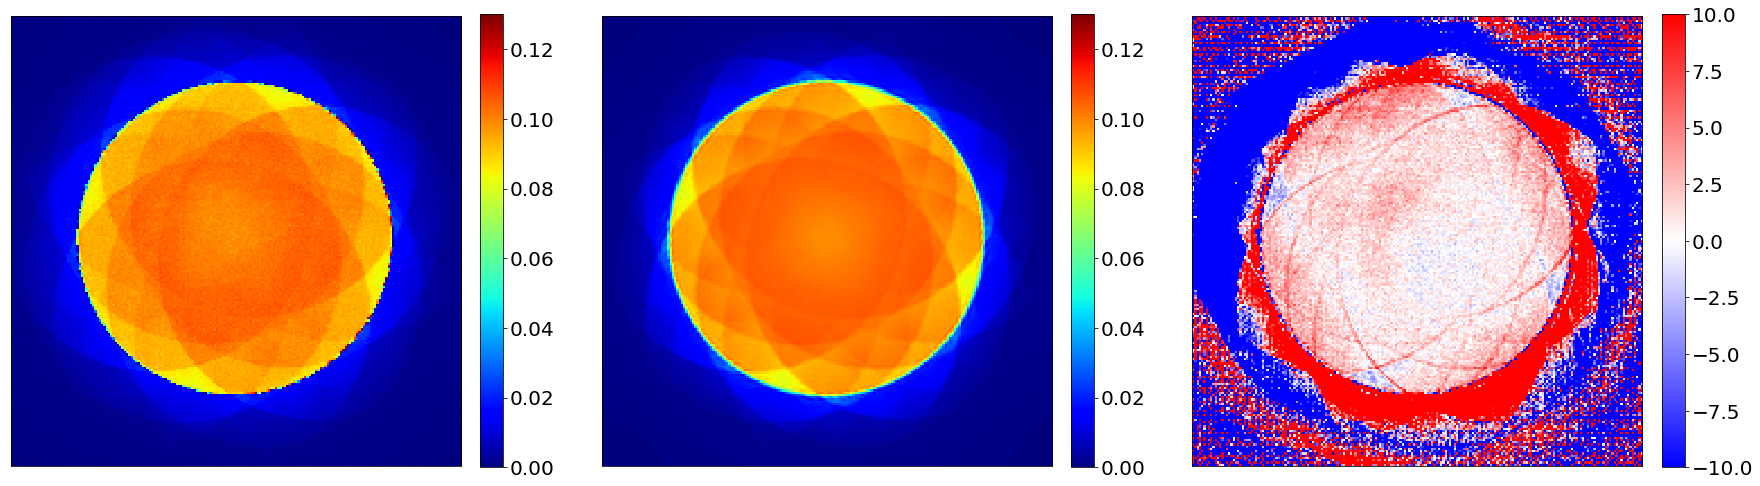

In [68]:
fig, ax = subplots(1,3,figsize=(30, 10))
im0 = ax[0].imshow(exp_recon*10000,clim=[0,0.13],cmap = plt.get_cmap('jet'))
im1 = ax[1].imshow(sim_recon*10000,clim=[0,0.13],cmap = plt.get_cmap('jet'))
# im1 = ax[1].imshow(sim_recon*10000)
cbar = plt.colorbar(im0,ax = ax[0], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20)
cbar = plt.colorbar(im1,ax = ax[1], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20)
im2 = ax[2].imshow(((sim_recon-exp_recon)/sim_recon*100),clim=[-10,10],cmap=plt.get_cmap('bwr'))
cbar = plt.colorbar(im2,ax = ax[2], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

/srv/home/chenyu/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


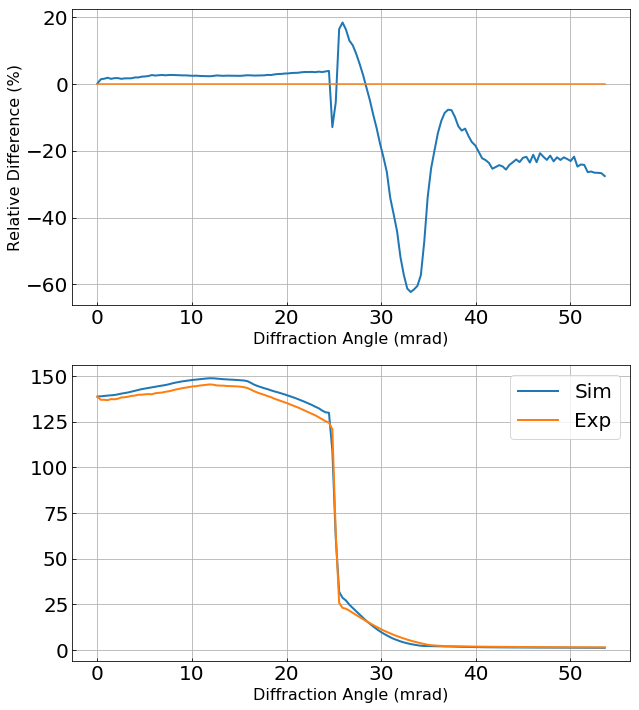

In [46]:
fig = plt.figure(figsize=(10,12))
diff_polar = convert((sim_recon-exp_recon)/sim_recon*100, [200, 200], center=[100, 100])
# diff_polar = convert((sim_recon-exp_recon)*BeamLevel, [200, 200], center=[100, 100])
diff_lineprofile = np.average(diff_polar,axis=1)

fig.add_subplot(211)
plt.plot(np.linspace(0,0.36*149,num=150),diff_lineprofile,linewidth = 2)
plt.plot(np.linspace(0,0.36*149,1000),np.linspace(0,0,1000))
# plt.ylim(-2,2)
# plt.ylim(-15,15)
plt.tick_params(labelsize=20,direction='in')
plt.grid('on')
plt.ylabel('Relative Difference (%)',fontsize=16)
# plt.ylabel('Absolute Difference (counts)',fontsize=16)
plt.xlabel('Diffraction Angle (mrad)',fontsize=16)

fig.add_subplot(212)
plt.plot(np.linspace(0,0.36*149,num=150),np.mean(convert(sim_recon,[200,200],center=[100,100]),axis=1)*BeamLevel,linewidth = 2,label='Sim')
plt.plot(np.linspace(0,0.36*149,num=150),np.mean(convert(exp_recon,[200,200],center=[100,100]),axis=1)*BeamLevel,linewidth = 2,label='Exp')
# plt.ylim(0,15)
# plt.ylim(-10,10)
# plt.yscale('log')
plt.tick_params(labelsize=20,direction='in')
plt.grid('on')
# plt.ylabel('Fractional Difference (%)',fontsize=16)
plt.xlabel('Diffraction Angle (mrad)',fontsize=16)
plt.legend(fontsize=20)

In [623]:
center_x = 255
center_y = 270
rotation = 0

final_size = 200

exp_pxsize = 0.150
sim_pxsize = 0.511

# Use a symmetric cutoff angle

collection_angle = min([center_x,center_y,512-center_x,512-center_y])
collection_angle = collection_angle * exp_pxsize

exp_x = np.linspace(-exp_pxsize*center_x, exp_pxsize*(511-center_x), num=512)
exp_y = np.linspace(-exp_pxsize*center_y, exp_pxsize*(511-center_y), num=512)
f_exp = scipy.interpolate.RectBivariateSpline(exp_y,exp_x,AccumulatedFrame)
final_x = np.linspace(-collection_angle,collection_angle,num=final_size)
final_y = np.linspace(-collection_angle,collection_angle,num=final_size)
final_xx, final_yy = np.meshgrid(final_x,final_y)
exp_recon = np.zeros((final_size,final_size))
exp_recon = f_exp.ev(final_xx,final_yy)

line = np.mean(convert(exp_recon, [200, 200], center=[100, 100]),axis=1)

/srv/home/chenyu/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Text(0, 0.5, 'Residual Intensity (counts)')

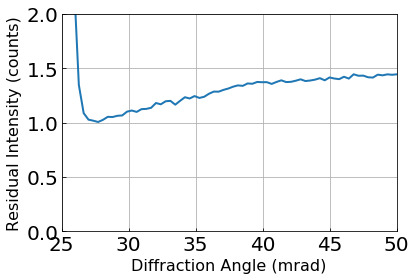

In [640]:
plt.plot(np.linspace(0,0.36*149,num=150),line,linewidth=2)
plt.ylim([0,2])
plt.xlim([25,50])
plt.tick_params(labelsize=20,direction='in')
plt.grid('on')
plt.xlabel('Diffraction Angle (mrad)',fontsize=16)
plt.ylabel('Residual Intensity (counts)',fontsize=16)

In [19]:
from scipy.interpolate import griddata
from numpy import exp, abs,angle
from scipy.interpolate import RectBivariateSpline

def convert (img, size, center, correction=False, plot=False):
    '''
    :param img: a 2-d array for the image to convert to polar coordinates
    :param center: x,y coordinates for the center of the image
    :param correction: the circular correction
    :param size: [x,y] describing the pixel dimensions of the photo
    :return: polar_img r vs. theta
    '''
    phase_width = 360
    r_inital = 0
    r_final =150
    final_theta, final_r = create_grid(np.linspace(-1*np.pi,np.pi,phase_width),np.arange(0,r_final,1))
#     initial_x, initial_y = create_grid(range(1,size[0]+1),range(1,size[1]+1))
#     initial_y, initial_x = range(1, 513), range(1, 513)
    initial_y, initial_x = range(1, size[0]+1), range(1, size[1]+1)
    final_x, final_y = polar_list_to_cartesian(final_r,final_theta,center)
    
    #initial_theta, initial_r = cartesian_list_to_polar(initial_x,initial_y,center)
#     inten = np.reshape(img,size[0]*size[1])
#     polar_img = griddata((initial_x,initial_y),inten,(final_x,final_y), method='linear')
    inten = img
    spline = RectBivariateSpline(initial_x, initial_y,inten,kx=1,ky=1)
    polar_img = spline.ev(final_x,final_y)
    
    polar_img = np.reshape(polar_img, [r_final, phase_width])
    if plot:
        plt.imshow(polar_img, extent=(0, 6.293, 0, 6))
        plt.show()
    return polar_img

def cartesian_to_polar(x,y,center):
    '''
    A function that converts the x,y coordinates to polar ones.
    -Does not do the circular correction
    '''
    corrected_x= x-center[0]
    corrected_y= y-center[1]
    theta = np.arctan2(corrected_y,corrected_x)
    r = np.sqrt(corrected_x**2+ corrected_y**2)
    return theta,r

def polar_to_cartesian(r, theta, center):
    x = center[0]+r*np.cos(theta)
    y = center[1] +r*np.sin(theta)
    return x,y

def cartesian_list_to_polar(x_list,y_list,center):
    theta_list = []
    r_list = []
    for x,y in zip(x_list,y_list):
        t,r =cartesian_to_polar(x,y,center)
        theta_list.append(t)
        r_list.append(r)
    return theta_list, r_list

def polar_list_to_cartesian(r_list,theta_list, center):
    x_list = []
    y_list = []
    for r, t in zip(r_list,theta_list):
        x,y = polar_to_cartesian(r,t,center)
        x_list.append(x)
        y_list.append(y)
    return x_list,y_list

def create_grid (dimension1,dimension2):
    '''
    Takes data from array of points turns it into a grid of coordinates
    '''
    dim1,dim2 =np.meshgrid(dimension1,dimension2)
    size = len(dimension1)*len(dimension2)
    a,b = np.reshape(dim1,size),np.reshape(dim2,size)
    return a,b

def circular_grid_data(intial_r, initial_theta, intensity, final_r,final_theta):
    #interpolating the radi and theta values from the cartesian points and mapping the intesities to evenly spaced
    # points in r an theta through linear interpolation... possibly some other interpolation....
    #for r,t in zip(final_r,final_theta):

    return


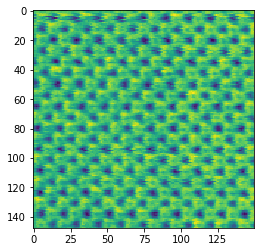

In [544]:
exppath = '/srv/home/chenyu/DEbackup/061219/S8/'
ABF = np.load(exppath+'ABF.npy')
plt.imshow(ABF[1:-1,:])

(-0.5, 149.5, 147.5, -0.5)

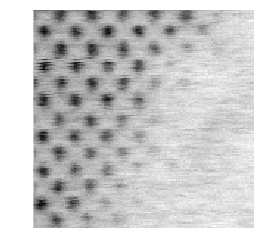

In [554]:
exppath = '/srv/home/chenyu/DEbackup/022119/S10/'
# PACBED_exp = np.load(exppath+'PACBED.npy')
# thickness = np.load(exppath+'SrPeaks_thickness.npy')
ABF = np.load(exppath+'BF.npy')
plt.imshow(ABF[1:-1,:],cmap='gray')
plt.axis('off')

In [577]:
rx = 150
ry = 150
exppath = '/srv/home/chenyu/DEbackup/022119/S10/'
AccumulatedFrame = np.zeros((512,512))
for ix in range(60,150):
    for iy in range(90,150):
        filenum = ix*rx+iy+1
        frame = np.load(exppath+'npy/S10_'+format(filenum,'05')+'.npy')
        AccumulatedFrame = AccumulatedFrame + frame
AccumulatedFrame = AccumulatedFrame / 90 / 60
PACBED_morph = AccumulatedFrame

(-0.5, 511.5, 511.5, -0.5)

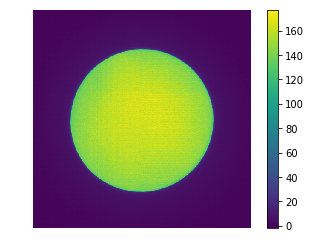

In [578]:
# BeamLevel = np.load('/srv/home/chenyu/DEbackup/022119/BeamLevel.npy')
# PACBED_morph = PACBED_morph / BeamLevel
plt.imshow(PACBED_morph)
plt.colorbar()
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

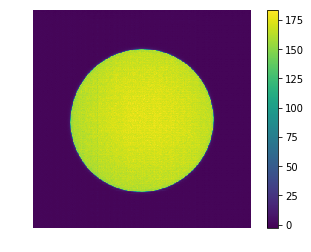

In [579]:
AccumulatedFrame = np.load('/srv/home/chenyu/DEbackup/022119/AccumulatedFrame.npy')
# AccumulatedFrame = AccumulatedFrame / BeamLevel
plt.imshow(AccumulatedFrame)
plt.colorbar()
plt.axis('off')

/srv/home/chenyu/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Text(0.5, 0, 'Diffraction Angle (mrad)')

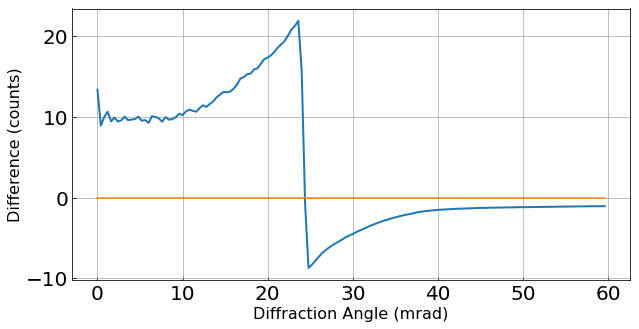

In [590]:
PACBED_exp = PACBED_morph
# dataset for 02/21/19
center_x = 255.8
center_y = 259.6
rotation = -27

final_size = 50
final_size = 200

exp_x = np.linspace(-exp_pxsize*center_x, exp_pxsize*(511-center_x), num=512)
exp_y = np.linspace(-exp_pxsize*center_y, exp_pxsize*(511-center_y), num=512)
f_exp = scipy.interpolate.RectBivariateSpline(exp_y,exp_x,PACBED_exp)
final_x = np.linspace(-40,40,num=final_size)
final_y = np.linspace(-40,40,num=final_size)
final_xx, final_yy = np.meshgrid(final_x,final_y)
exp_recon = np.zeros((final_size,final_size))
exp_recon = f_exp.ev(final_xx,final_yy)
lineprofile_morph = np.mean(convert(exp_recon,[200,200],center=[100,100]),axis=1)
# plt.plot(np.linspace(0,0.4*149,num=150),np.mean(convert(exp_recon,[200,200],center=[100,100]),axis=1),linewidth = 2,label='Amorphous region')

PACBED_exp = AccumulatedFrame
f_exp = scipy.interpolate.RectBivariateSpline(exp_y,exp_x,PACBED_exp)
final_x = np.linspace(-40,40,num=final_size)
final_y = np.linspace(-40,40,num=final_size)
final_xx, final_yy = np.meshgrid(final_x,final_y)
exp_recon = np.zeros((final_size,final_size))
exp_recon = f_exp.ev(final_xx,final_yy)
lineprofile_nosample = np.mean(convert(exp_recon,[200,200],center=[100,100]),axis=1)
# plt.plot(np.linspace(0,0.4*149,num=150),np.mean(convert(exp_recon,[200,200],center=[100,100]),axis=1),linewidth = 2,label='No sample')

diff_lineprofile = lineprofile_nosample - lineprofile_morph

fig = plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,0.4*149,num=150),diff_lineprofile,linewidth = 2)
plt.plot(np.linspace(0,0.4*149,1000),np.linspace(0,0,1000))
# plt.ylim(-2,2)
# plt.ylim(-10,10)
plt.tick_params(labelsize=20,direction='in')
plt.grid('on')
plt.ylabel('Difference (counts)',fontsize=16)
plt.xlabel('Diffraction Angle (mrad)',fontsize=16)



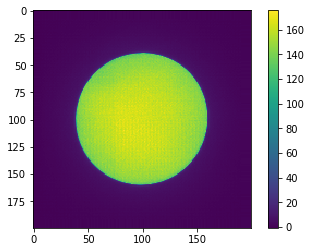

In [582]:
plt.imshow(exp_recon)
plt.colorbar()